In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

from torchsummary import summary

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [2]:
num_per_class = 1000
image_size = 91

x = np.linspace(-4, 4, image_size)
x, y = np.meshgrid(x, x)

widths = np.linspace(2, 20, num_per_class)

original_images = torch.zeros(num_per_class, 1, image_size, image_size)
occluded_images = torch.zeros(num_per_class, 1, image_size, image_size)

for i in range(num_per_class):
    random_offset = 1.5*np.random.randn(2)
    gaussian = np.exp(-((x - random_offset[0])**2 + (y - random_offset[1])**2)/(widths[i]))

    gaussian = gaussian + np.random.randn(image_size, image_size)/5
    
    original_images[i, :, :, :] = torch.Tensor(gaussian).view(1, image_size, image_size)

    i_1 = np.random.choice(np.arange(2, 28))
    i_2 = np.random.choice(np.arange(2, 6))
    if np.random.randn() > 0:
        gaussian[i_1:i_1+i_2, ] = 1
    else:
        gaussian[:, i_1:i_1+i_2] = 1
    
    occluded_images[i, :, :, :] = torch.Tensor(gaussian).view(1, image_size, image_size)

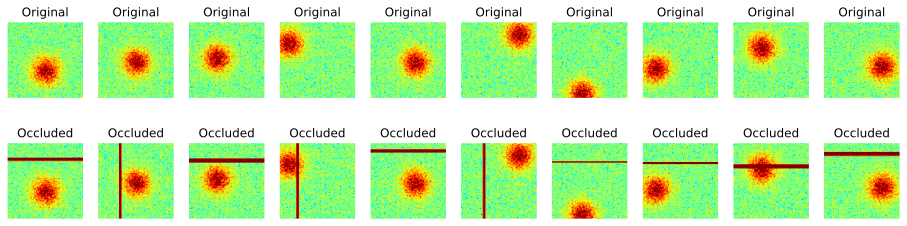

In [3]:
_, axis = plt.subplots(2, 10, figsize=(16, 4))

for i in range(10):
    axis[0, i].imshow(np.squeeze(original_images[i, :, :]), vmin=-1, vmax=1, cmap="jet")
    axis[0, i].axis("off")
    axis[0, i].set_title("Original")
    
    axis[1, i].imshow(np.squeeze(occluded_images[i, :, :]), vmin=-1, vmax=1, cmap="jet")
    axis[1, i].axis("off")
    axis[1, i].set_title("Occluded")

plt.show()

In [4]:
class L1Loss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, y_hat, y):
        loss = torch.mean(torch.abs(y_hat - y))
        return loss

In [5]:
class L2AvgLoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, y_hat, y):
        loss = torch.mean(torch.square(y_hat - y)) + torch.abs(torch.mean(y_hat))
        return loss

In [6]:
class CorrLoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, y_hat, y):
        loss = -torch.sum((y_hat - torch.mean(y_hat)) * (y - torch.mean(y))) / ((torch.numel(y) - 1) * torch.std(y_hat) * torch.std(y))
        return loss

In [7]:
def model():
    
    class AutoEncoders(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.enc = nn.Sequential(
                nn.Conv2d(1, 6, 3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
                nn.Conv2d(6, 4, 3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2)
            )
            
            self.dec = nn.Sequential(
                nn.ConvTranspose2d(4, 6, 3, 2),
                nn.ReLU(),
                nn.ConvTranspose2d(6, 1, 3, 2)
            )
            
        def forward(self, x):
            return self.dec(self.enc(x))
        
    autoencoders = AutoEncoders()
    
    loss_fun = nn.MSELoss()
    
    # loss_fun = L1Loss()
    # loss_fun = L2AvgLoss
    # loss_fun = CorrLoss()
    
    optimizer = torch.optim.Adam(autoencoders.parameters(), lr=0.001)
    
    return autoencoders, loss_fun, optimizer

In [8]:
summary(model()[0], (1, image_size, image_size))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 4, 22, 22]           --
|    └─Conv2d: 2-1                       [-1, 6, 91, 91]           60
|    └─ReLU: 2-2                         [-1, 6, 91, 91]           --
|    └─MaxPool2d: 2-3                    [-1, 6, 45, 45]           --
|    └─Conv2d: 2-4                       [-1, 4, 45, 45]           220
|    └─ReLU: 2-5                         [-1, 4, 45, 45]           --
|    └─MaxPool2d: 2-6                    [-1, 4, 22, 22]           --
├─Sequential: 1-2                        [-1, 1, 91, 91]           --
|    └─ConvTranspose2d: 2-7              [-1, 6, 45, 45]           222
|    └─ReLU: 2-8                         [-1, 6, 45, 45]           --
|    └─ConvTranspose2d: 2-9              [-1, 1, 91, 91]           55
Total params: 557
Trainable params: 557
Non-trainable params: 0
Total mult-adds (M): 1.77
Input size (MB): 0.03
Forward/backward pass size (MB): 0.60
Par

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 4, 22, 22]           --
|    └─Conv2d: 2-1                       [-1, 6, 91, 91]           60
|    └─ReLU: 2-2                         [-1, 6, 91, 91]           --
|    └─MaxPool2d: 2-3                    [-1, 6, 45, 45]           --
|    └─Conv2d: 2-4                       [-1, 4, 45, 45]           220
|    └─ReLU: 2-5                         [-1, 4, 45, 45]           --
|    └─MaxPool2d: 2-6                    [-1, 4, 22, 22]           --
├─Sequential: 1-2                        [-1, 1, 91, 91]           --
|    └─ConvTranspose2d: 2-7              [-1, 6, 45, 45]           222
|    └─ReLU: 2-8                         [-1, 6, 45, 45]           --
|    └─ConvTranspose2d: 2-9              [-1, 1, 91, 91]           55
Total params: 557
Trainable params: 557
Non-trainable params: 0
Total mult-adds (M): 1.77
Input size (MB): 0.03
Forward/backward pass size (MB): 0.60
Par

In [9]:
def train_model():
    
    num_epochs = 550

    autoencoders, loss_fun, optimizer = model()
    
    losses = []
    
    for epoch in range(num_epochs):
        pics = np.random.choice(num_per_class, size=32, replace=False)
        original = original_images[pics, :, :, :]
        occluded = occluded_images[pics, :, :, :]
        
        y_hat = autoencoders(occluded)
        loss = loss_fun(y_hat, original)
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    return losses, autoencoders

In [10]:
losses, autoencoders = train_model()

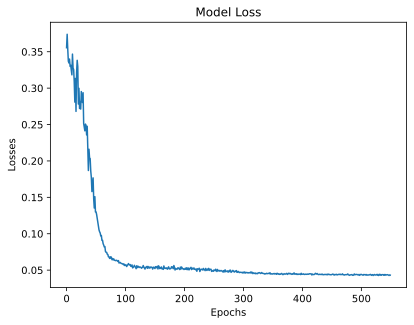

In [11]:
plt.plot(losses, "-", label="Train")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Model Loss");

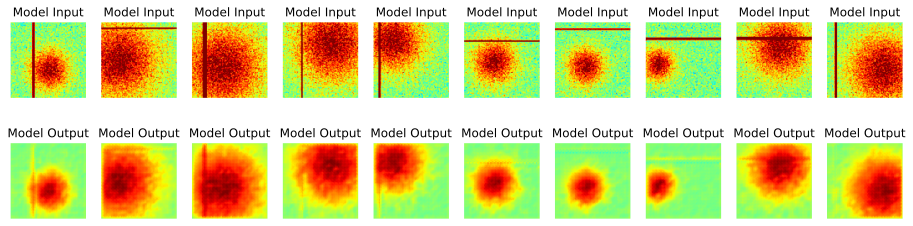

In [12]:
pics = np.random.choice(num_per_class, size=32, replace=True)
x = occluded_images[pics, :, :, :]

y_hat = autoencoders(x)

_, axis = plt.subplots(2, 10, figsize=(16, 4))

for i in range(10):
    gaussian = torch.squeeze(x[i, 0, :, :]).detach()
    output = torch.squeeze(y_hat[i, 0, :, :]).detach()
    
    axis[0, i].imshow(gaussian, vmin=-1, vmax=1, cmap="jet")
    axis[0, i].axis("off")
    axis[0, i].set_title("Model Input")
    
    axis[1, i].imshow(output, vmin=-1, vmax=1, cmap="jet")
    axis[1, i].axis("off")
    axis[1, i].set_title("Model Output")

plt.show()